# Forecasting with scikit-learn Regressors using Reduction in sktime

This tutorial demonstrates how traditional machine learning models from **scikit-learn** can be used for time series forecasting through **reduction techniques** in **sktime**.

Reduction transforms a forecasting problem into a supervised regression task, allowing us to leverage powerful tabular models for temporal prediction.

---

## Learning Objectives

By the end of this tutorial you will:

- Understand reduction-based forecasting
- Learn the difference between **recursive** and **direct** strategies
- Convert time series into tabular features using **WindowSummarizer**
- Build forecasting pipelines
- Understand why preprocessing such as **differencing** is critical for trend extrapolation


In [1]:
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

from sktime.forecasting.compose import make_reduction, ForecastingPipeline
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.base import ForecastingHorizon
import warnings
warnings.filterwarnings("ignore")


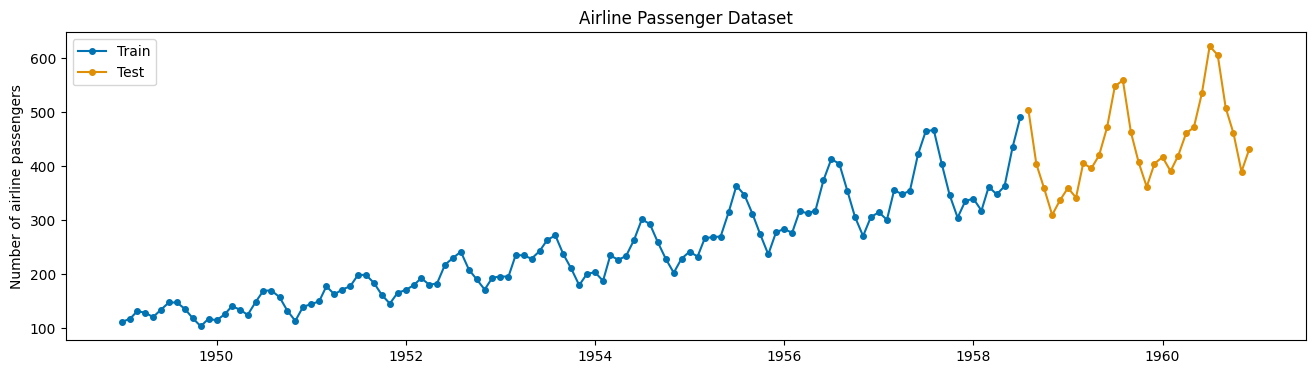

In [2]:
y = load_airline()

y_train, y_test = temporal_train_test_split(y, test_size=0.2)

plot_series(y_train, y_test, labels=["Train", "Test"])
plt.title("Airline Passenger Dataset")
plt.show()


## What is Reduction?

Reduction is a strategy that converts a time series forecasting problem into a supervised machine learning task.

Instead of modeling temporal dependencies directly, past observations are transformed into tabular features that can be used by standard regressors.

This enables us to use the rich ecosystem of **scikit-learn** models for forecasting.


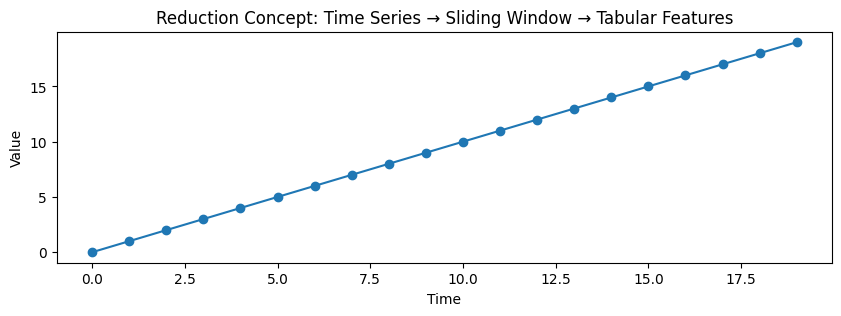

In [3]:
import numpy as np

series = np.arange(20)

plt.figure(figsize=(10,3))
plt.plot(series, marker='o')
plt.title("Reduction Concept: Time Series → Sliding Window → Tabular Features")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


## Creating Tabular Features with WindowSummarizer

`WindowSummarizer` automatically extracts lagged values and summary statistics from the time series.

These tabular features allow regression models to learn temporal structure.


In [4]:
window = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3, 12],
        "mean": [[1, 3]]
    }
)


## Recursive Reduction Strategy

The recursive strategy trains **one model** and generates forecasts step-by-step.

Predictions are fed back into the model to forecast further ahead.


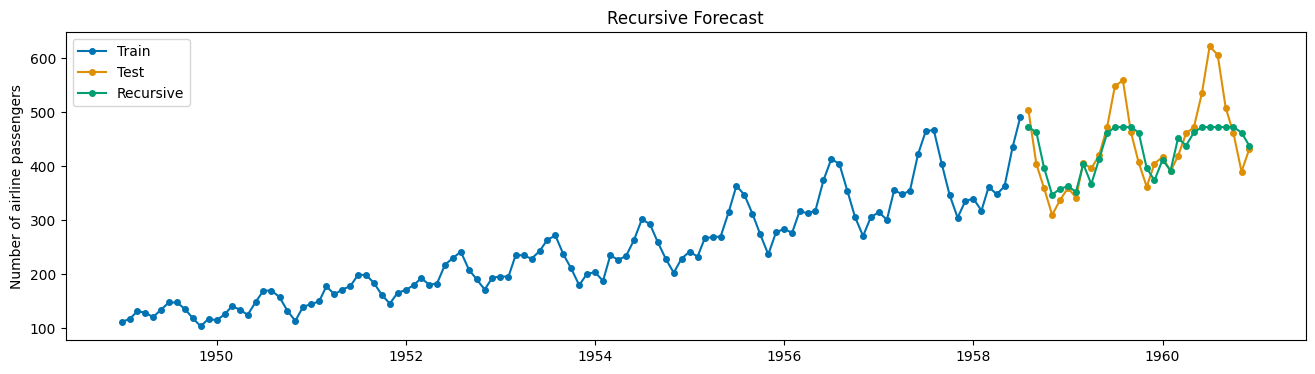

In [5]:
forecaster_recursive = make_reduction(
    RandomForestRegressor(random_state=42),
    window_length=None,   # VERY IMPORTANT
    strategy="recursive",
    transformers=[window],
    pooling="global"

)

fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster_recursive.fit(y_train)
pred_recursive = forecaster_recursive.predict(fh)

plot_series(y_train, y_test, pred_recursive,
            labels=["Train", "Test", "Recursive"])
plt.title("Recursive Forecast")
plt.show()


## Direct Reduction Strategy

The direct strategy trains **separate models for each forecasting horizon**.

It is often more stable for long-range forecasts since it avoids error propagation.


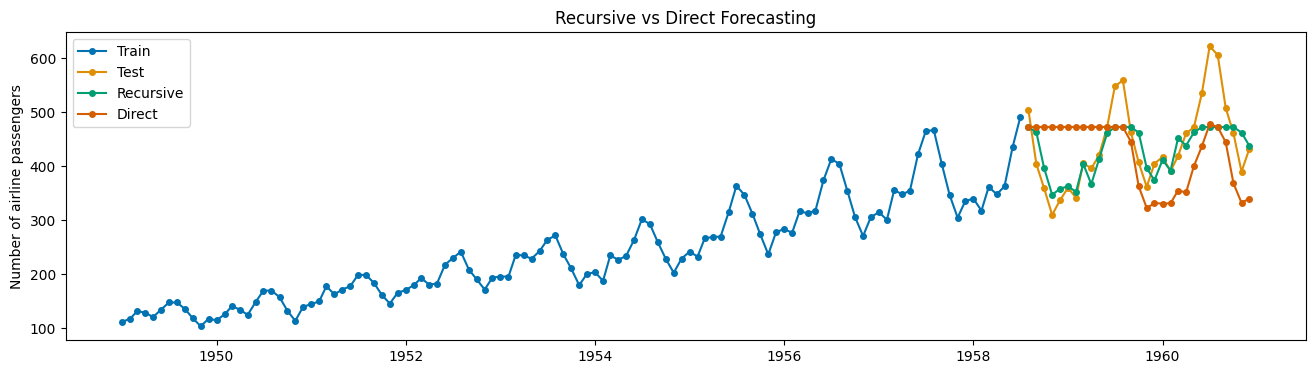

In [6]:
forecaster_direct = make_reduction(
    RandomForestRegressor(random_state=42),
    window_length=None,
    strategy="direct",
    transformers=[window] ,
    pooling="global"

)

forecaster_direct.fit(y_train, fh=fh)
pred_direct = forecaster_direct.predict(fh)

plot_series(
    y_train, y_test, pred_recursive, pred_direct,
    labels=["Train", "Test", "Recursive", "Direct"]
)
plt.title("Recursive vs Direct Forecasting")
plt.show()


## Why Differencing Matters

Machine learning regressors typically struggle to extrapolate trends.

Differencing helps remove trend components, allowing the model to focus on learning patterns in the stationary signal.

Below we compare long-term forecasts **with and without differencing**.


In [7]:
no_diff = make_reduction(
    RandomForestRegressor(random_state=42),
    window_length=None,
    strategy="recursive",
    transformers=[window],
    pooling="global"

)

no_diff.fit(y_train)
pred_no_diff = no_diff.predict(fh)


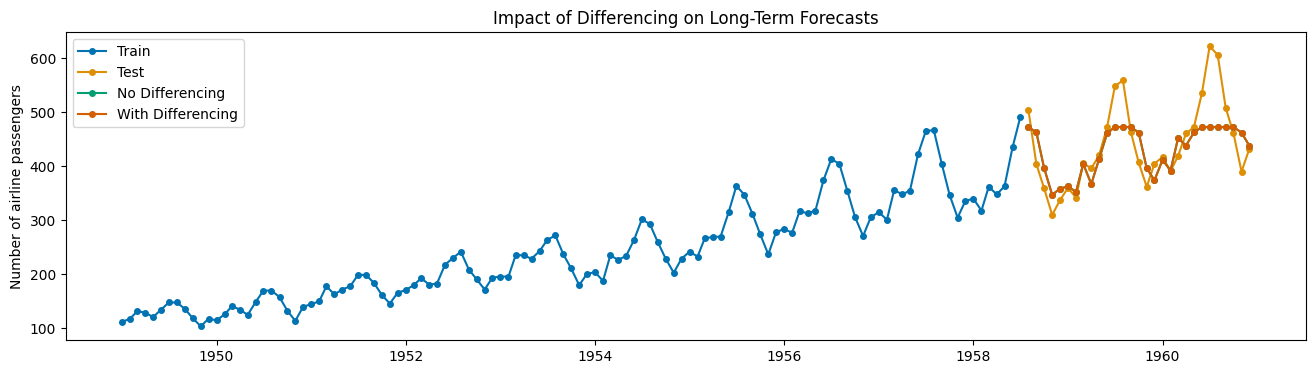

In [8]:
pipeline = ForecastingPipeline(steps=[
    ("differencer", Differencer()),
    ("forecaster", make_reduction(
        RandomForestRegressor(random_state=42),
        window_length=None,
        strategy="recursive",
        transformers=[window],
        pooling="global"

    ))
])

pipeline.fit(y_train)
pred_diff = pipeline.predict(fh)

plot_series(
    y_train, y_test, pred_no_diff, pred_diff,
    labels=["Train", "Test", "No Differencing", "With Differencing"]
)
plt.title("Impact of Differencing on Long-Term Forecasts")
plt.show()


## Key Takeaways

- Reduction enables scikit-learn regressors to solve forecasting tasks.
- WindowSummarizer provides an efficient way to create tabular features from time series.
- Recursive and direct strategies offer different trade-offs between speed and stability.
- Preprocessing steps such as differencing are often essential for capturing trends.
- sktime pipelines allow seamless integration of transformations and forecasting models.
